In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install torch
!pip install torchvision
!pip install tensorflow
!pip install Cython
!pip install torch torchvision tensorboardx

In [0]:
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import numpy as np

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import time
import os
from os.path import join
from tqdm import tqdm_notebook as tqdm

from PIL import Image
import matplotlib.pyplot as plt

import cv2

In [0]:
!unzip "/content/drive/My Drive/data.zip"

In [5]:
%load_ext tensorboard
!rm -rf ./logs

# Writer will output to ./runs/ directory by default
log_subdir = join('./logs', time.strftime("%Y-%m-%d-%H-%M-%S"))  # creates new timestamped subdir for every new run
writer = SummaryWriter(log_dir=log_subdir)
print('Log subdirectory: ', log_subdir)

Log subdirectory:  ./logs/2019-12-04-00-14-20


In [0]:
dataset_path = "data/"
folder_paths = list(sorted(os.listdir(dataset_path)))

#the dataset came with masks for each stain, here to sum all masks into one
for path in folder_paths:
  mask_paths = list(os.listdir(os.path.join(dataset_path, path, "masks")))
  sum_mask = cv2.imread(os.path.join(dataset_path, path, "masks", mask_paths[0]), 0)
  for mask_path in mask_paths:
    curr_mask = cv2.imread(os.path.join(dataset_path, path, "masks", mask_path), 0)
    sum_mask = np.maximum(sum_mask, curr_mask)
  cv2.imwrite(os.path.join(dataset_path, path, "mask.png") ,sum_mask)

In [0]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.folder_paths = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.folder_paths[idx], "image.png")
        mask_path = os.path.join(self.root, self.folder_paths[idx], "mask.png")
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transforms is not None:
            img = self.transforms[0](img)
            mask = self.transforms[1](mask)
            
        return img, mask

    def __len__(self):
        return len(self.folder_paths)

In [0]:
class FCNet(nn.Module):

    def __init__(self, kernel_size, num_filters):
        super(FCNet, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Sequential(nn.Conv2d(4, num_filters, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters, num_filters, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)) #1/2

        self.conv2 = nn.Sequential(nn.Conv2d(num_filters, num_filters*2, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*2),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters*2, num_filters*2, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)) #1/4

        self.conv3 = nn.Sequential(nn.Conv2d(num_filters*2, num_filters*4, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*4),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters*4, num_filters*4, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*4),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters*4, num_filters*4, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*4),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)) #1/8

        self.conv4 = nn.Sequential(nn.Conv2d(num_filters*4, num_filters*8, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*8),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters*8, num_filters*8, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*8),
                                   nn.ReLU(),
                                   nn.Conv2d(num_filters*8, num_filters*8, kernel_size, padding=padding),
                                   nn.BatchNorm2d(num_filters*8),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)) #1/16
        
        self.fc1 = nn.Sequential(nn.Conv2d(num_filters*8, num_filters*32, kernel_size+4, padding=padding+2),
                                 nn.BatchNorm2d(num_filters*32),
                                 nn.ReLU(),
                                 nn.Dropout2d())

        self.fc2 = nn.Sequential(nn.Conv2d(num_filters*32, num_filters*32, kernel_size, padding=padding),
                                 nn.BatchNorm2d(num_filters*32),
                                 nn.ReLU(),
                                 nn.Dropout2d())

        self.score_fr = nn.Conv2d(num_filters*32, num_filters, kernel_size, padding=padding)
        self.upscore = nn.ConvTranspose2d(num_filters, 1, 16, stride=16)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.out1 = self.conv1(x)
        self.out2 = self.conv2(self.out1)
        self.out3 = self.conv3(self.out2)
        self.out4 = self.conv4(self.out3)

        self.out5 = self.fc1(self.out4)
        self.out6 = self.fc2(self.out5)

        self.out7 = self.score_fr(self.out6)

        self.out_final = self.upscore(self.out7)
        
        return self.sigmoid(self.out_final)

In [0]:
class UNet(nn.Module):

    def __init__(self, kernel_size, num_filters):
        super(UNet, self).__init__()
        padding = kernel_size // 2
        self.down_conv1 = nn.Sequential(nn.Conv2d(4, num_filters, kernel_size, padding=padding),
                                        nn.BatchNorm2d(num_filters),
                                        nn.ReLU(),
                                        nn.Conv2d(num_filters, num_filters, kernel_size, padding=padding),
                                        nn.BatchNorm2d(num_filters),
                                        nn.ReLU())
        self.down_conv2 = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Conv2d(num_filters, num_filters * 2, 1),
                                        nn.BatchNorm2d(num_filters*2),
                                        nn.ReLU(),
                                        nn.Conv2d(num_filters * 2, num_filters * 2, kernel_size, padding=padding),
                                        nn.BatchNorm2d(num_filters*2),
                                        nn.ReLU())
        
        self.down_conv3 = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Conv2d(num_filters*2, num_filters * 4, 1),
                                        nn.BatchNorm2d(num_filters*4),
                                        nn.ReLU(),
                                        nn.Conv2d(num_filters*4, num_filters * 4, kernel_size, padding=padding),
                                        nn.BatchNorm2d(num_filters*4),
                                        nn.ReLU())

        self.bot_conv = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Conv2d(num_filters*4, num_filters * 8, 1),
                                        nn.BatchNorm2d(num_filters*8),
                                        nn.ReLU(),
                                        nn.Conv2d(num_filters*8, num_filters * 4, kernel_size, padding=padding),
                                        nn.BatchNorm2d(num_filters*4),
                                        nn.ReLU(),
                                        nn.Upsample(scale_factor=2))

        self.up_conv1 = nn.Sequential(nn.Conv2d(num_filters * 8, num_filters * 4, kernel_size, padding=padding),
                                      nn.ReLU(),
                                      nn.Conv2d(num_filters * 4, num_filters * 2, kernel_size, padding=padding),
                                      nn.BatchNorm2d(num_filters*2),
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2))

        self.up_conv2 = nn.Sequential(nn.Conv2d(num_filters * 4, num_filters * 2, kernel_size, padding=padding),
                                      nn.ReLU(),
                                      nn.Conv2d(num_filters * 2, num_filters, kernel_size, padding=padding),
                                      nn.BatchNorm2d(num_filters),
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2))
        
        self.up_conv3 = nn.Sequential(nn.Conv2d(num_filters * 2, num_filters, kernel_size, padding=padding),
                                      nn.ReLU(),
                                      nn.Conv2d(num_filters, 4, kernel_size, padding=padding),
                                      nn.BatchNorm2d(4),
                                      nn.ReLU())
               
        self.final_conv = nn.Sequential(nn.Conv2d(4 + 4, 2, kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.Conv2d(2, 1, kernel_size, padding=padding),
                                        nn.ReLU(),
                                        nn.Sigmoid())
        
    def forward(self, x):
        self.out1 = self.down_conv1(x)
        self.out2 = self.down_conv2(self.out1)
        self.out3 = self.down_conv3(self.out2)
        
        self.out4 = self.bot_conv(self.out3)
        
        self.out5 = self.up_conv1(torch.cat((self.out4, self.out3), dim=1))
        self.out6 = self.up_conv2(torch.cat((self.out5, self.out2), dim=1))
        self.out7 = self.up_conv3(torch.cat((self.out6, self.out1), dim=1))

        self.out_final = self.final_conv(torch.cat((self.out7, x), dim=1))
        
        return self.out_final


In [0]:
#Canny Edge Detection method, detect edges from img,
#lowThresholdRatio stands for the lower bound of gradients,
#gradient values below max gradient * lowThresholdRatio are ignored
#highThresholdRatio is used to determine strong and weak edges
#gradient values in between of maxGradient * lowTR and maxGradient * highTR are weak edges
#gradient values larger than maxGradient * highTR are strong edges
def myCannyEdge(img, lowThresholdRatio, highThresholdRatio):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  blur_img = cv2.GaussianBlur(gray_img,(5,5),cv2.BORDER_DEFAULT)

  #calculate the gradients with directions
  Ix = np.abs(cv2.Sobel(blur_img, cv2.CV_64F, 1, 0))
  Iy = np.abs(cv2.Sobel(blur_img, cv2.CV_64F, 0, 1))
  gradient = np.hypot(Ix, Iy)
  gradient = gradient / gradient.max() * 255
  theta = np.arctan2(Iy, Ix)

  H, W = blur_img.shape

  gray_img[gray_img==255] = 0
  # assume none of the pixels in photos taken has intensity 0 (at least some photons are captured), so the 
  # only 0 intensity pixels are caused by noises or segmentation of clothes, so we should ignore the edges
  # come from those pixels
  central_gradient = gradient[1:H-1, 1:W-1]
  central_gradient[gray_img[0:H-2, 1:W-1] == 0] = 0
  central_gradient[gray_img[2:H, 1:W-1] == 0] = 0
  central_gradient[gray_img[1:H-1, 0:W-2] == 0] = 0
  central_gradient[gray_img[1:H-1, 2:W] == 0] = 0

  #non-maximum suppression
  edges = np.zeros((H,W), dtype=np.int32)
  angle = theta * 180. / np.pi
  angle[angle < 0] += 180

  q = np.ones((H-2,W-2)) * 255
  r = np.ones((H-2,W-2)) * 255

  meaningful_angle = angle[1:H-1, 1:W-1]
  #angle 0
  curr_indices = np.logical_or(meaningful_angle<22.5, meaningful_angle >= 157.5)
  q[curr_indices] = (gradient[1:H-1, 2:H])[curr_indices]
  r[curr_indices] = (gradient[1:H-1, 0:H-2])[curr_indices]

  #angle 45
  curr_indices = np.logical_and(meaningful_angle<67.5, meaningful_angle >= 22.5)
  q[curr_indices] = (gradient[2:H, 0:H-2])[curr_indices]
  r[curr_indices] = (gradient[0:H-2, 2:H])[curr_indices]

  #angle 90
  curr_indices = np.logical_and(meaningful_angle<112.5, meaningful_angle >= 67.5)
  q[curr_indices] = (gradient[2:H, 1:H-1])[curr_indices]
  r[curr_indices] = (gradient[0:H-2, 1:H-1])[curr_indices]

  #angle 135
  curr_indices = np.logical_and(meaningful_angle<157.5, meaningful_angle >= 112.5)
  q[curr_indices] = (gradient[0:H-2, 0:H-2])[curr_indices]
  r[curr_indices] = (gradient[2:H, 2:H])[curr_indices]

  #store only the local max gradient
  curr_indices = gradient[1:H-1, 1:W-1] >= np.maximum(q, r)
  (edges[1:H-1, 1:W-1])[curr_indices] = (gradient[1:H-1, 1:W-1])[curr_indices]
  
  #high and low thresholding
  highThreshold = edges.max() * highThresholdRatio;
  lowThreshold = edges.max() * lowThresholdRatio;

  res = np.zeros((H,W), dtype=np.int32)
  
  weak = np.int32(25)
  strong = np.int32(255)
  
  strong_i, strong_j = np.where(edges >= highThreshold)
  zeros_i, zeros_j = np.where(edges < lowThreshold)
  
  weak_i, weak_j = np.where((edges <= highThreshold) & (edges >= lowThreshold))
  
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak

  #track through the weak edges and accept the ones near to strong edges
  for i in range(1, H-1):
      for j in range(1, W-1):
          if (res[i,j] == weak):
              try:
                  if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                      or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                      or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                      res[i, j] = strong
                  else:
                      res[i, j] = 0
              except IndexError as e:
                  pass
  return res

In [0]:
#add edges to be the 4th channel of input
#edges are detected by Canny Edge Detection method
def preprocess(input_imgs):
  with torch.no_grad():
    batches, _, h, w = input_imgs.shape
    edges = torch.zeros(batches, 1, h, w, requires_grad=True)

    input_copy = input_imgs * 1
    for i in range(input_imgs.shape[0]):
      edge = torch.from_numpy(myCannyEdge(np.uint8((input_imgs[i].permute(1,2,0).numpy())*255), 0.05, 0.5))
      edges[i, 0, :, :] = edge/255
 
  return torch.cat((input_copy, edges), dim=1)


In [0]:
import random
import skimage as sk

#generates augmented data

!rm -rf ./aug_data
os.mkdir("aug_data/")

def rotation(image, mask):
  # pick a random degree of rotation between 25 on the left and 25 on the right
  random_degree = random.uniform(-25, 25)
  return sk.transform.rotate(image, random_degree), sk.transform.rotate(mask, random_degree)

def zoom(image, mask):
  # pick a random scale between 4 and 4/3 to zoom in
  random_scale = random.uniform(0.25, 0.75)
  return sk.transform.rescale(image, random_scale), sk.transform.rotate(mask, random_scale)

def random_coloring(image):
  random_color = np.random.ranf(3) / 2
  new_img = image * 1
  new_img[:, :, 0] += random_color[0]
  new_img[:, :, 1] += random_color[1]
  new_img[:, :, 2] += random_color[2]

  new_img = new_img / np.max(new_img)
  return new_img

data_paths = list(sorted(os.listdir("data")))
aug_methods = [rotation, zoom]

num_data_generate = 800
count = 0
for i in range(num_data_generate):
  aug_method = aug_methods[random.randint(0,1)]
  data_path = data_paths[i%len(data_paths)]

  image_path = os.path.join("data", data_path, "images")
  image = sk.io.imread(os.path.join(image_path, list(os.listdir(image_path))[0]))
  mask = sk.io.imread(os.path.join("data", data_path, "mask.png"))
  
  os.mkdir("aug_data/%s" % (count))
  new_img, new_mask = aug_method(image, mask)
  new_img = random_coloring(new_img)

  if(np.max(new_img) > 1 or np.max(new_mask) > 1):
    print(np.max(new_img))
    print(np.max(new_mask))

  new_img = np.uint8(new_img * 255)
  new_mask = np.uint8(new_mask * 255)

  sk.io.imsave("aug_data/%s/image.png" % (count), new_img)
  sk.io.imsave("aug_data/%s/mask.png" % (count), new_mask)
  count = count + 1


In [0]:
#transformation for Unet datasets
#image_transforms = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
#mask_transforms = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

#transformation for FCN datasets
image_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
mask_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = SegmentationDataset("aug_data", [image_transforms, mask_transforms])

batch_size = 4
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and test splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [0]:
#model = UNet(3, 16)
model = FCNet(3, 4)

#writer.add_graph(model, torch.zeros(8, 4, 512, 512))

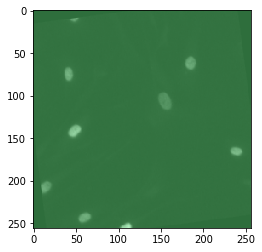

In [124]:
dataiter = iter(train_loader)
image, mask = dataiter.next()

plt.imshow(image[0].permute([1,2,0]))

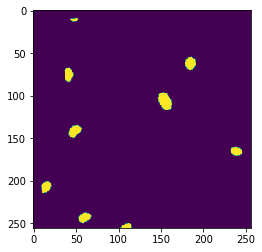

In [0]:
plt.imshow(mask[0,0])

In [0]:
def myDiceCoefLoss(pred, target):
    smooth = 1.0
    target[target < 0.5] = 0
    target[target >= 0.5] = 1

    tp = torch.dot(pred.reshape(-1), target.reshape(-1))
    total = torch.sum(pred) + torch.sum(target)
    
    return 1 - (2.0 * tp + smooth) / (total + smooth)

def myAccuracy(pred, target):
    batches, channels, h, w = pred.shape
    pixels = batches * channels * h * w

    target[target < 0.5] = 0
    target[target >= 0.5] = 1
    
    pred = pred / torch.max(pred)

    miss_match = torch.sum(torch.abs(pred - target))
    return 1 - miss_match / pixels

In [0]:
class AverageMeter(object):
  """Simple class to compute and keep track of a metrics average.
      It could be smarter and more efficient, but it will do.
  """
  def __init__(self, window_size=None):
      self.avg = 0
      self.sum = 0
      self.count = 0
      self.data = []
      self.window_size = window_size

  def reset(self):
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, weight=1):
      if self.window_size:
          self.data.append(val*weight)
          if self.window_size < len(self.data):
              self.data.pop(0)
          self.sum = sum(self.data)
          self.count = len(self.data)
          self.avg = self.sum / self.count
      else:
          self.sum += val * weight
          self.count += weight
          self.avg = self.sum / self.count


def fit_epoch(model, dataset, optimizer, criterion, batch_size, sampler):
  loss_meter = AverageMeter()
  acc_meter = AverageMeter()
  model.train()
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler, pin_memory=True, drop_last=True)
  for batch_idx, (features, target) in enumerate(tqdm(train_loader)):
    optimizer.zero_grad()

    inputs = preprocess(features)

    inputs = inputs.cuda()
    target = target.cuda()

    preds = model(inputs)
    #preds_prob = torch.softmax(preds, dim=1)
    loss = criterion(preds, target)
    # preds = torch.squeeze(preds)
    loss.backward()
    optimizer.step()
    loss_meter.update(float(loss.detach().cpu()))
    acc_meter.update(myAccuracy(preds, target))
    if batch_idx % 20 == 0:
      for n, p in model.named_parameters():
        writer.add_histogram(n, p.detach().cpu().numpy(), epoch*len(train_loader) + batch_idx)

    del inputs
    del target
  return loss_meter.avg, acc_meter.avg


def validate(model, dataset, criterion, batch_size, sampler):
  model.eval()
  loss_meter = AverageMeter()
  acc_meter = AverageMeter()
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler, pin_memory=True, drop_last=True)
  for features, target in tqdm(val_loader):
      inputs = preprocess(features)

      inputs = inputs.cuda()
      target = target.cuda()

      preds = model(inputs)

      loss = criterion(preds, target)
      loss_meter.update(float(loss.detach().cpu()))
      acc_meter.update(myAccuracy(preds, target))

      del inputs
      del target
  return loss_meter.avg, acc_meter.avg


In [169]:
optimizer = Adam(model.parameters(), lr=0.03)
criterion = myDiceCoefLoss

epochs = 10
model.cuda()

pbar = tqdm(range(epochs))
for epoch in tqdm(range(epochs)):
  ! torch.cuda.empty_cache()

  val_loss, val_acc = validate(model, dataset, criterion, 8, test_sampler)
  loss, acc = fit_epoch(model, dataset, optimizer, criterion, 8, train_sampler)  
  pbar.set_description('Loss: {:.2f} | Accuracy: {:.2f} | Val_Loss: {:.2f} | Val_Accuracy: {:.2f}'.format(loss, acc, val_loss, val_acc))
  writer.add_scalar('Train Loss', loss, epoch)
  writer.add_scalar('Train Accuracy', acc, epoch)
  writer.add_scalar('Validation Loss', val_loss, epoch)
  writer.add_scalar('Validation Accuracy', val_acc, epoch)
  writer.flush()
  #print(f"Training loss: {loss}")
  #print(f"Training accuracy: {acc}")
  #print(f"Test loss: {val_loss}")
  #print(f"Test accuracy: {val_acc}")

/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
writer.close()

In [171]:
%tensorboard --logdir='./logs'

Reusing TensorBoard on port 6006 (pid 2414), started 0:35:59 ago. (Use '!kill 2414' to kill it.)

In [0]:
dataiter = iter(test_loader)
image, mask = dataiter.next()

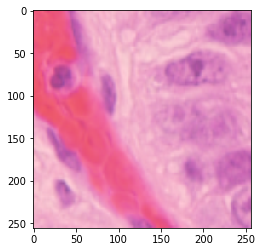

In [173]:
inputs = preprocess(image)

result = model(inputs.cuda())
cv2.imwrite("data_sample.jpg", inputs[2,:3].permute([1,2,0]).detach().numpy() * 255)
plt.imshow(inputs[2,:3].permute([1,2,0]).detach())

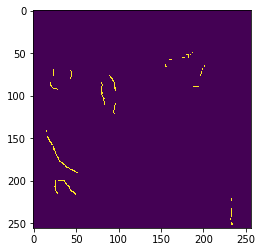

In [174]:
cv2.imwrite("canny_set.jpg", inputs[2,3].detach().numpy()*255)
plt.imshow(inputs[2,3].detach().numpy())

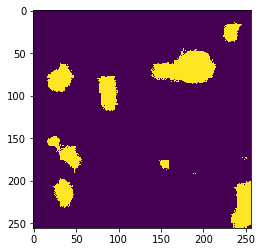

In [175]:
plt.imshow(result.detach().cpu()[2,0])

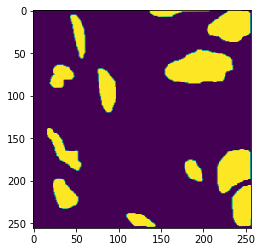

In [176]:
plt.imshow(mask[2,0])

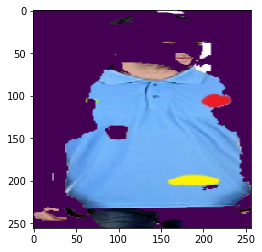

In [217]:
the_img = Image.open("sample2.png").convert("RGB")
the_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

the_img = the_transforms(the_img).reshape((1,3,256,256))
the_input = preprocess(the_img)
#the_input[0, 3] = 0

result = model(the_input.cuda())
result = result / torch.max(result)

plt.imshow(the_input[0, :3].permute([1,2,0]).detach().cpu())

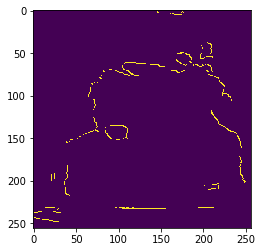

In [218]:
cv2.imwrite("canny_test.jpg", the_input[0,3].detach().numpy()*255)
plt.imshow(the_input[0, 3].detach())

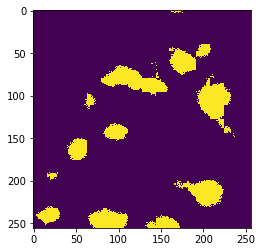

In [219]:
plt.imshow(result.detach().cpu()[0,0])

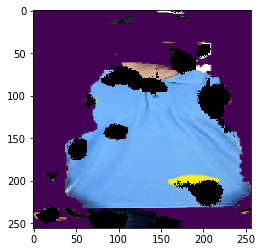

In [220]:
seg_img = the_img[0].permute([1,2,0]).detach() * 1

seg_img[result[0,0] > 0.5, :] = 0

plt.imshow(seg_img.numpy())

In [221]:
cv2.imwrite("seg_result.jpg", seg_img.numpy()*255//1)
cv2.imwrite("mask.jpg", result[0,0].cpu().detach().numpy()*255//1)

True